In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

In [2]:
def get_X_y(data):
    """"
    Returns the X and y of the data

    :returns X, y
    """
    return data.loc[:, data.columns != 'Classification'], data['Classification']



In [3]:
# Creating the pipeline
features_num = [
    "AGNfrac_af", "AGNfrac_af_16", "AGNfrac_cg_s", "AGNfrac_cg_s_16", "AGNfrac_cg_f", "AGNfrac_cg_f_16", 
    "Chi_sq_MpBp", "Chi_sq_AfCg", "Mass_conc", "SFR_conc", "Radio_excess", "Radio_excess_DJS"
]
features_cat = [
    "Spitzer_SN", "Donley", "Lacy", "Stern", "Messias", "KI", "Ch2_Ch4", 
    "Ch4_24mu", "Xray", "Opt_spec", "Extended_radio"
]
features_drop = [
    "Source_Name", "Radio_ID", "AGN_final", "IDOptical", "IDSpitzer"
]
transformer_num = make_pipeline(
    SimpleImputer(),  # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [4]:
data = pd.read_csv("../Data/Cleaned/Combined_secure_class.csv")
X, y = get_X_y(data)
X = X.drop(columns=features_drop)

# Transforming y from categorical to numerical
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

C:\Users\jespe\AppData\Local\Temp\ipykernel_2484\22415563.py:1: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/Cleaned/Combined_secure_class.csv")


In [5]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [6]:
# Transforming the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Random Forest

In [7]:
clf = RandomForestClassifier(n_estimators=10, class_weight=None)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [8]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9569    0.9843    0.9704      3884
quasar-like radio AGN / high-excitation radio galaxy     0.8351    0.8396    0.8373       374
                                     radio-quiet AGN     0.9336    0.9259    0.9298      2066
                                 star-forming galaxy     0.9906    0.9850    0.9878     16959

                                            accuracy                         0.9773     23283
                                           macro avg     0.9291    0.9337    0.9313     23283
                                        weighted avg     0.9774    0.9773    0.9773     23283



[]

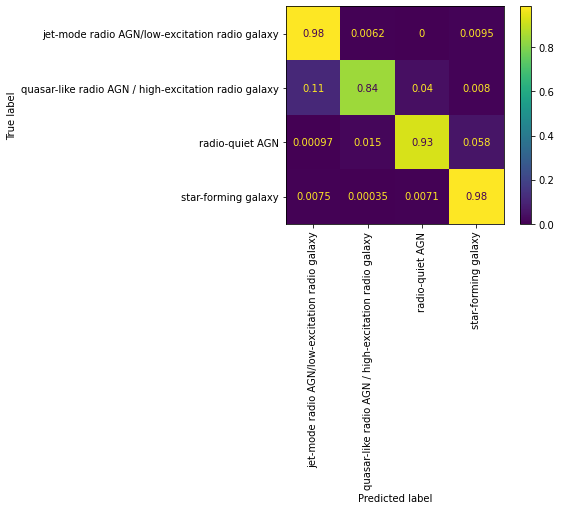

In [9]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [10]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
random_forest_feature_importance = random_forest_feature_importance.sort_values(by=['Importance'], ascending=False)

[Text(0, 0, 'pipeline-1__Radio_excess'),
 Text(1, 0, 'pipeline-1__Radio_excess_DJS'),
 Text(2, 0, 'pipeline-1__AGNfrac_af_16'),
 Text(3, 0, 'pipeline-1__AGNfrac_cg_s_16'),
 Text(4, 0, 'pipeline-1__AGNfrac_cg_s'),
 Text(5, 0, 'pipeline-1__SFR_conc'),
 Text(6, 0, 'pipeline-1__AGNfrac_cg_f_16'),
 Text(7, 0, 'pipeline-2__Extended_radio_0.0'),
 Text(8, 0, 'pipeline-1__Chi_sq_MpBp'),
 Text(9, 0, 'pipeline-1__AGNfrac_af'),
 Text(10, 0, 'pipeline-1__Mass_conc'),
 Text(11, 0, 'pipeline-1__AGNfrac_cg_f'),
 Text(12, 0, 'pipeline-1__Chi_sq_AfCg'),
 Text(13, 0, 'pipeline-2__Opt_spec_0.0'),
 Text(14, 0, 'pipeline-2__Extended_radio_1.0'),
 Text(15, 0, 'pipeline-2__Opt_spec_1.0'),
 Text(16, 0, 'pipeline-2__Stern_1.0'),
 Text(17, 0, 'pipeline-2__KI_-99.0'),
 Text(18, 0, 'pipeline-2__Xray_0.0'),
 Text(19, 0, 'pipeline-2__Xray_1.0'),
 Text(20, 0, 'pipeline-2__Donley_1.0'),
 Text(21, 0, 'pipeline-2__Spitzer_SN_2.0'),
 Text(22, 0, 'pipeline-2__KI_0.0'),
 Text(23, 0, 'pipeline-2__Messias_1.0'),
 Text(24, 0,

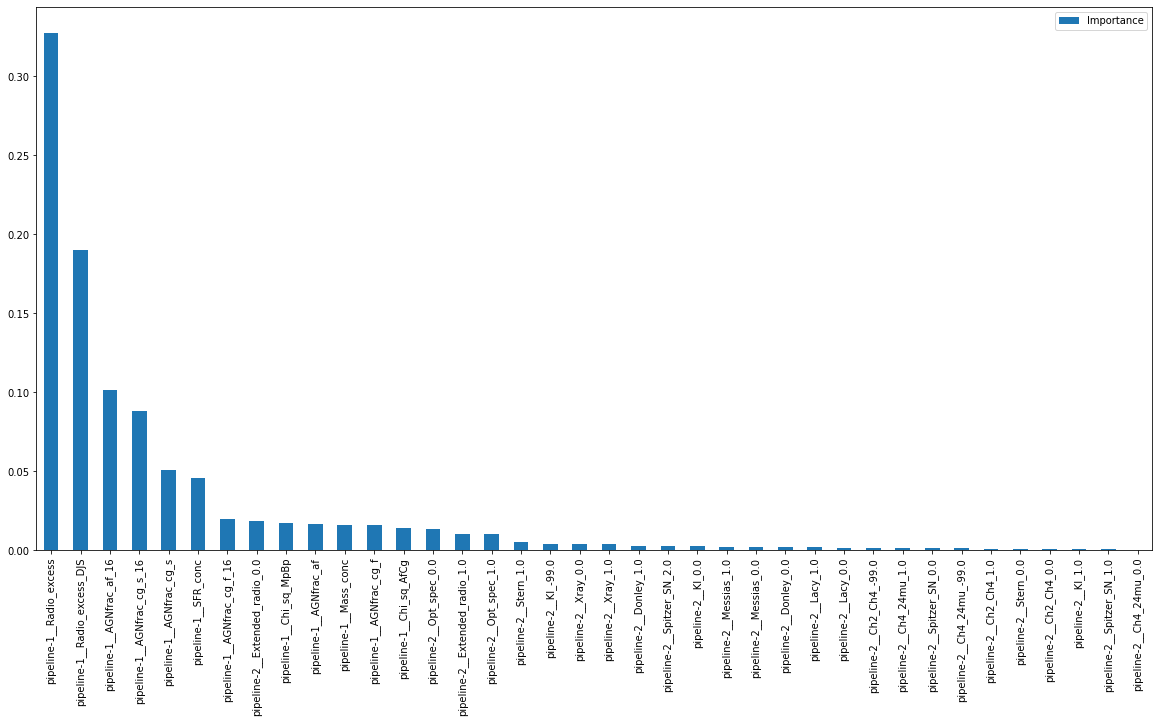

In [11]:
ax = random_forest_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(random_forest_feature_importance.Feature)

In [12]:
random_forest_feature_importance['cumulative_sum'] = random_forest_feature_importance['Importance'].cumsum()
random_forest_feature_importance = random_forest_feature_importance.reset_index()
random_forest_feature_importance

,index,Feature,Importance,cumulative_sum
0,10,pipeline-1__Radio_excess,0.327481,0.327481
1,11,pipeline-1__Radio_excess_DJS,0.190013,0.517494
2,1,pipeline-1__AGNfrac_af_16,0.101418,0.618912
3,3,pipeline-1__AGNfrac_cg_s_16,0.087941,0.706852
4,2,pipeline-1__AGNfrac_cg_s,0.050784,0.757636
5,9,pipeline-1__SFR_conc,0.045878,0.803514
6,5,pipeline-1__AGNfrac_cg_f_16,0.019659,0.823173
7,36,pipeline-2__Extended_radio_0.0,0.01846,0.841633
8,6,pipeline-1__Chi_sq_MpBp,0.016998,0.858631
9,0,pipeline-1__AGNfrac_af,0.01645,0.875081


# XGBoost

In [13]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:0.87760
[1]	validation_0-mlogloss:0.61480
[2]	validation_0-mlogloss:0.44871
[3]	validation_0-mlogloss:0.33608
[4]	validation_0-mlogloss:0.25715
[5]	validation_0-mlogloss:0.20092
[6]	validation_0-mlogloss:0.16020
[7]	validation_0-mlogloss:0.13058
[8]	validation_0-mlogloss:0.10897
[9]	validation_0-mlogloss:0.09289
[10]	validation_0-mlogloss:0.08091
[11]	validation_0-mlogloss:0.07198
[12]	validation_0-mlogloss:0.06525
[13]	validation_0-mlogloss:0.06015
[14]	validation_0-mlogloss:0.05630
[15]	validation_0-mlogloss:0.05337
[16]	validation_0-mlogloss:0.05115
[17]	validation_0-mlogloss:0.04927
[18]	validation_0-mlogloss:0.04788
[19]	validation_0-mlogloss:0.04691
[20]	validation_0-mlogloss:0.04612
[21]	validation_0-mlogloss:0.04539
[22]	validation_0-mlogloss:0.04479
[23]	validation_0-mlogloss:0.04435
[24]	validation_0-mlogloss:0.04396
[25]	validation_0-mlogloss:0.04347
[26]	validation_0-mlogloss:0.04316
[27]	validation_0-mlogloss:0.04291
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [14]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9730    0.9848    0.9789      3884
quasar-like radio AGN / high-excitation radio galaxy     0.8658    0.9144    0.8895       374
                                     radio-quiet AGN     0.9534    0.9501    0.9518      2066
                                 star-forming galaxy     0.9934    0.9898    0.9916     16959

                                            accuracy                         0.9842     23283
                                           macro avg     0.9464    0.9598    0.9529     23283
                                        weighted avg     0.9844    0.9842    0.9843     23283



[]

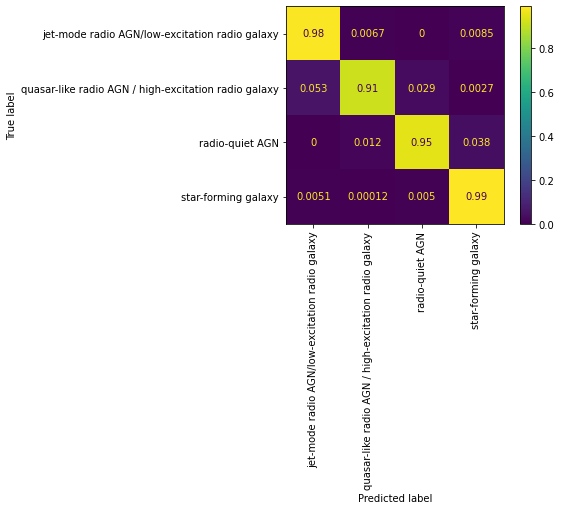

In [15]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [16]:
xgboost_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), model.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
xgboost_feature_importance = xgboost_feature_importance.sort_values(by=['Importance'], ascending=False)

[Text(0, 0, 'pipeline-1__Radio_excess'),
 Text(1, 0, 'pipeline-1__AGNfrac_af_16'),
 Text(2, 0, 'pipeline-1__AGNfrac_cg_s_16'),
 Text(3, 0, 'pipeline-2__Extended_radio_0.0'),
 Text(4, 0, 'pipeline-2__Opt_spec_0.0'),
 Text(5, 0, 'pipeline-2__Xray_0.0'),
 Text(6, 0, 'pipeline-2__Messias_0.0'),
 Text(7, 0, 'pipeline-2__Ch2_Ch4_0.0'),
 Text(8, 0, 'pipeline-2__Spitzer_SN_2.0'),
 Text(9, 0, 'pipeline-2__Spitzer_SN_0.0'),
 Text(10, 0, 'pipeline-2__Ch2_Ch4_-99.0'),
 Text(11, 0, 'pipeline-1__Chi_sq_MpBp'),
 Text(12, 0, 'pipeline-1__Chi_sq_AfCg'),
 Text(13, 0, 'pipeline-2__Lacy_0.0'),
 Text(14, 0, 'pipeline-2__KI_0.0'),
 Text(15, 0, 'pipeline-1__AGNfrac_cg_s'),
 Text(16, 0, 'pipeline-2__Ch4_24mu_0.0'),
 Text(17, 0, 'pipeline-2__KI_-99.0'),
 Text(18, 0, 'pipeline-2__Ch2_Ch4_1.0'),
 Text(19, 0, 'pipeline-2__Donley_0.0'),
 Text(20, 0, 'pipeline-1__SFR_conc'),
 Text(21, 0, 'pipeline-2__Ch4_24mu_1.0'),
 Text(22, 0, 'pipeline-1__Radio_excess_DJS'),
 Text(23, 0, 'pipeline-1__AGNfrac_af'),
 Text(24, 0, '

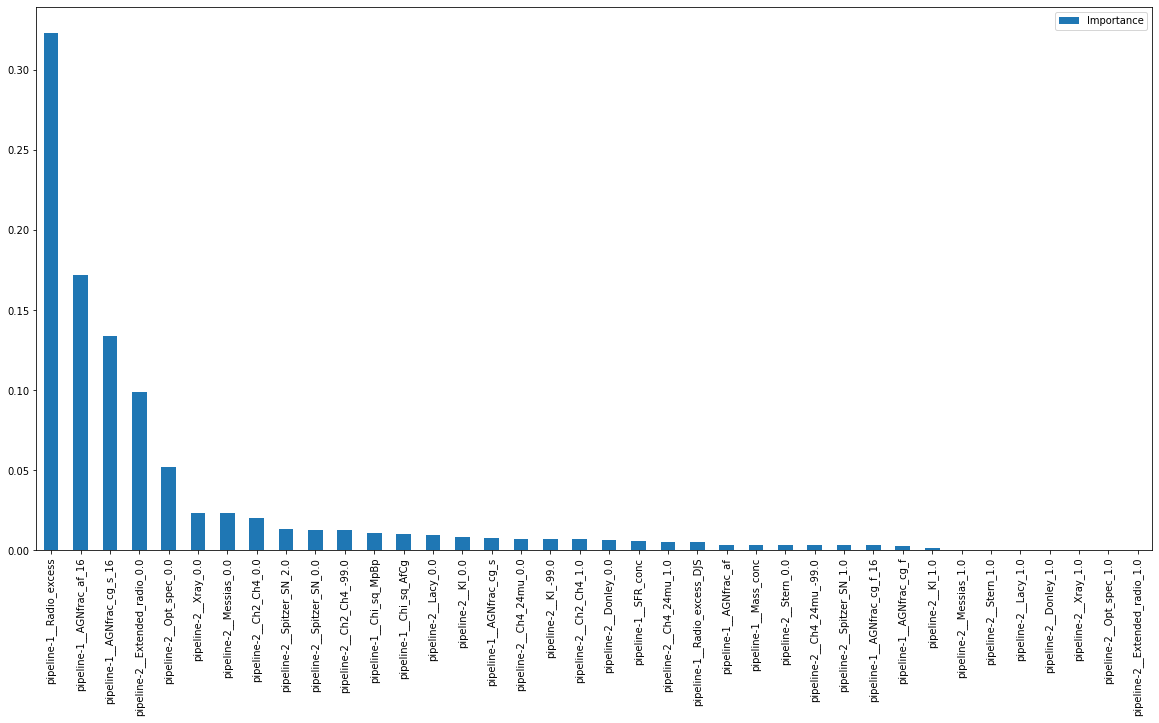

In [17]:
ax = xgboost_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(xgboost_feature_importance.Feature)

In [18]:
xgboost_feature_importance['cumulative_sum'] = xgboost_feature_importance['Importance'].cumsum()
xgboost_feature_importance = xgboost_feature_importance.reset_index()
xgboost_feature_importance

,index,Feature,Importance,cumulative_sum
0,10,pipeline-1__Radio_excess,0.323207,0.323207
1,1,pipeline-1__AGNfrac_af_16,0.171774,0.494981
2,3,pipeline-1__AGNfrac_cg_s_16,0.133649,0.62863
3,36,pipeline-2__Extended_radio_0.0,0.098895,0.727525
4,34,pipeline-2__Opt_spec_0.0,0.052057,0.779582
5,32,pipeline-2__Xray_0.0,0.023432,0.803014
6,21,pipeline-2__Messias_0.0,0.023313,0.826327
7,27,pipeline-2__Ch2_Ch4_0.0,0.020168,0.846495
8,14,pipeline-2__Spitzer_SN_2.0,0.013176,0.859671
9,12,pipeline-2__Spitzer_SN_0.0,0.012978,0.872649


# SVM

In [19]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [20]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9691    0.9531    0.9611      3884
quasar-like radio AGN / high-excitation radio galaxy     0.8452    0.7594    0.8000       374
                                     radio-quiet AGN     0.9218    0.9066    0.9141      2066
                                 star-forming galaxy     0.9807    0.9886    0.9846     16959

                                            accuracy                         0.9717     23283
                                           macro avg     0.9292    0.9019    0.9149     23283
                                        weighted avg     0.9714    0.9717    0.9715     23283



[]

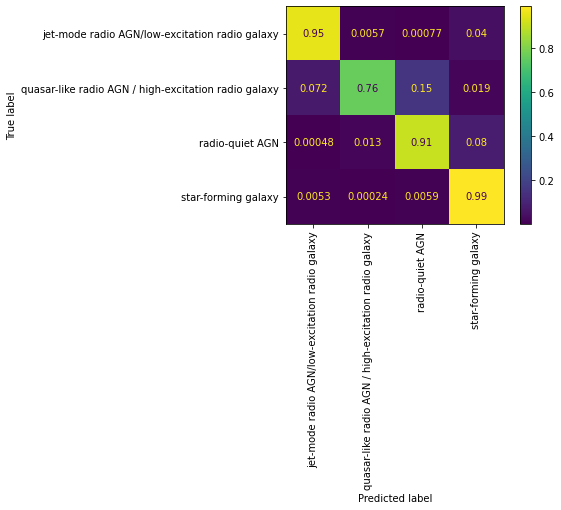

In [21]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Less feature

In [22]:
#Radio_excess = X[['Radio_excess']]
#Radio_excess = X[['Radio_excess', 'AGNfrac_af_16', 'AGNfrac_cg_s_16']]
Radio_excess = X[['Radio_excess', 'AGNfrac_af_16']]

In [23]:
# Creating training and testing set
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(Radio_excess, y, train_size=0.7)

In [24]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train_re, y_train_re, early_stopping_rounds=3, eval_set=[(X_test_re, y_test_re)], verbose=True)

[0]	validation_0-mlogloss:0.92982
[1]	validation_0-mlogloss:0.69180


C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mlogloss:0.54161
[3]	validation_0-mlogloss:0.44040
[4]	validation_0-mlogloss:0.37017
[5]	validation_0-mlogloss:0.32049
[6]	validation_0-mlogloss:0.28500
[7]	validation_0-mlogloss:0.25942
[8]	validation_0-mlogloss:0.24097
[9]	validation_0-mlogloss:0.22760
[10]	validation_0-mlogloss:0.21795
[11]	validation_0-mlogloss:0.21102
[12]	validation_0-mlogloss:0.20584
[13]	validation_0-mlogloss:0.20218
[14]	validation_0-mlogloss:0.19949
[15]	validation_0-mlogloss:0.19748
[16]	validation_0-mlogloss:0.19614
[17]	validation_0-mlogloss:0.19506
[18]	validation_0-mlogloss:0.19427
[19]	validation_0-mlogloss:0.19367
[20]	validation_0-mlogloss:0.19324
[21]	validation_0-mlogloss:0.19288
[22]	validation_0-mlogloss:0.19264
[23]	validation_0-mlogloss:0.19240
[24]	validation_0-mlogloss:0.19228
[25]	validation_0-mlogloss:0.19223
[26]	validation_0-mlogloss:0.19218
[27]	validation_0-mlogloss:0.19214
[28]	validation_0-mlogloss:0.19215
[29]	validation_0-mlogloss:0.19210
[30]	validation_0-mlogloss:0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [25]:
y_pred_re = model.predict(X_test_re)
print(classification_report(y_test_re, y_pred_re, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9380    0.9244    0.9312      3877
quasar-like radio AGN / high-excitation radio galaxy     0.5408    0.7083    0.6133       384
                                     radio-quiet AGN     0.6834    0.7608    0.7201      2074
                                 star-forming galaxy     0.9650    0.9480    0.9564     16948

                                            accuracy                         0.9235     23283
                                           macro avg     0.7818    0.8354    0.8052     23283
                                        weighted avg     0.9284    0.9235    0.9255     23283



[]

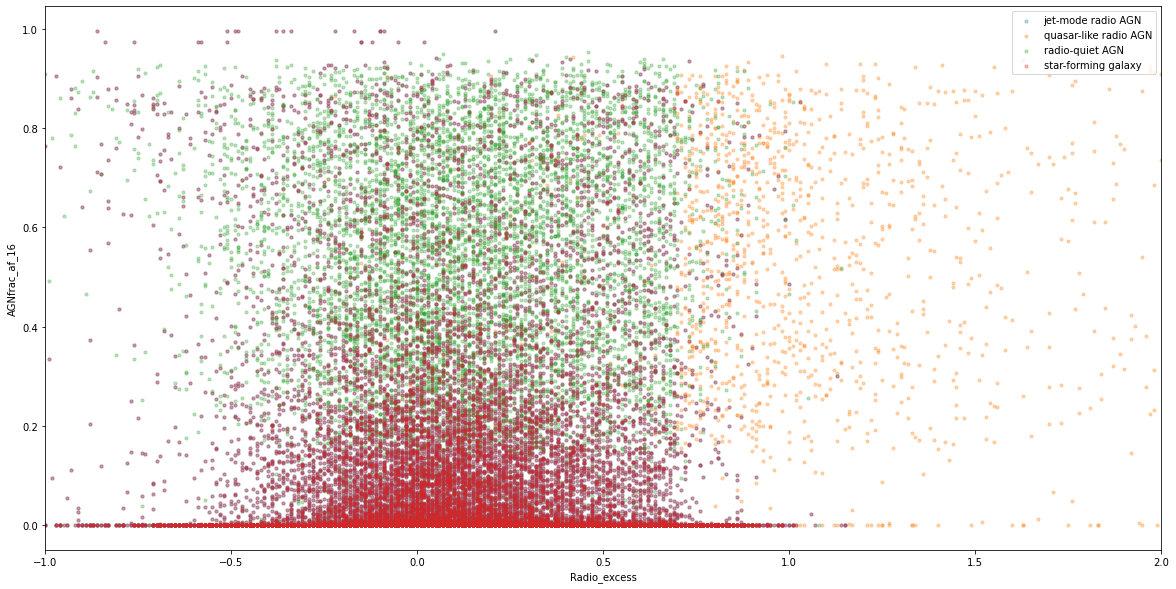

In [41]:
jet = data[data['Classification'] == 'star-forming galaxy']
quasar = data[data['Classification'] == 'quasar-like radio AGN / high-excitation radio galaxy']
quiet = data[data['Classification'] == 'radio-quiet AGN']
sfg = data[data['Classification'] == 'star-forming galaxy']

size = 10

plt.figure(figsize=(20,10))
plt.scatter(jet['Radio_excess'], jet['AGNfrac_af_16'], alpha=0.3, s=size, label='jet-mode radio AGN')
plt.scatter(quasar['Radio_excess'], quasar['AGNfrac_af_16'], alpha=0.3, s=size, label='quasar-like radio AGN')
plt.scatter(quiet['Radio_excess'], quiet['AGNfrac_af_16'], alpha=0.3, s=size, label='radio-quiet AGN')
plt.scatter(sfg['Radio_excess'], sfg['AGNfrac_af_16'], alpha=0.3, s=size, label='star-forming galaxy')
plt.xlabel('Radio_excess')
plt.ylabel('AGNfrac_af_16')
plt.xlim(-1,2)
plt.legend()
plt.plot()